# 基于泊松分布量化分析网关前置限流所需要的概念展开、计算公式推导与代码实现

- 关于『网关前置限流分析想要解决的问题』的说明与讨论，参见 `README.md`。
- 关于泊松分布，参见 [Notebook 泊松分布的简介、代码实现与概率分布图像](poisson_intro.ipynb)。

泊松分布的概率分布/概率质量函数的实现：

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sc


def poisson(lmd, k, exact=False):
    """
    泊松分布
    :param lmd: 泊松分布的 λ 参数（向量/标量）。
                对应限流问题的『单机收到的`QPS`』（压测发出的`QPS`实际上是平均值/期望）
    :param k: 观察到的次数，随机变量（向量/标量），函数返回的是 X = k次 时概率
              关联的是 限流问题中的『单机限流`QPS`』；X > 单机的限流`QPS`时，即出现限流。
    :param exact: `factorial`运算时是否`exact`
    :return: poisson(λ, k)的概率值（向量/标量）
              与 限流问题中的『限流比率』 相关，具体关系，在下面Cell中展开说明
    """
    return np.exp(-lmd) * np.power(lmd, k) / sc.factorial(k, exact=exact)

# 1. 通过 泊松分布的出现概率$P(\lambda)$ 求解 限流问题

已知量 |  代号
:------- | --------
流量`QPS` / 接收到的`QPS`（$RecivedQPS$，是`QPS`平均值）| $\lambda$
业务`QPS` / 业务峰值`QPS`($BizQps$) | $B$
限流`QPS`阈值 | $K$

要计算求出 

求解量 |  代号
:------- | --------
限流比例 | $LimitedRatio$
**限流`QPS`偏差比例** | $LimitedQpsErrorRatio$

## 关于『限流`QPS`偏差（比例）』

关于 偏差的正负

- 阈值设置了10 `QPS`，在小流量（流量不到10 `QPS`，如5 `QPS`）时，
    - 如果实际通过`QPS`不到5，则是限流多了（期望通过10），**偏差为正**。
- 阈值设置了10 `QPS`，在大流量时（大于10 `QPS`），
    - 如果实际通过`QPS`不到10，则是限流多了（期望通过10），**偏差为正**。
    - 如果实际通过`QPS`多于10，则是限流少了（期望通过10），**偏差为负**。
- 对应的**大家平时的说法**：
    - 对于正的偏差，即限流多了：
        - **提前限流**
    - 对于负的偏差，限流少了：
        - **没限住**
        - **多漏了流量**

# 2. 先求 限流`QPS`、通过`QPS`

## 2.0 关于`QPS`限流

- 当观察到的`QPS` $>$ 限流`QPS`阈值，即 $k > K$ 时，通过$K$ `QPS`，限流/拒绝 $k - K$ `QPS`。
- 当观察到的`QPS` $<$ 限流`QPS`阈值，即 $k <= K$ 时，通过$k$ `QPS`，限流/拒绝 $0$ `QPS`。

## 2.1 限流`QPS`

限流`QPS`，实际上是，限流`QPS` 的 **_期望_**，即是：

$$
LimitedQps(\lambda, K) =
\sum_{k=K+1}^{\infty}
    (k - K) P(\lambda, k)
\tag{1.1}
$$

## 2.2 通过`QPS`

$$
PassQps(\lambda, K) =
\sum_{k=0}^{K}
    k P(\lambda, k)
+
\sum_{k=K+1}^{\infty}
    K P(\lambda, k)
\tag{1.2}
$$

或是可以通过 总的`QPS`（$\lambda$）减去 限流`QPS` 来求：

$$
PassQps(\lambda, K) =
\lambda - LimitedQps(\lambda, K)
\tag{1.2.1}
$$

## 2.3 用户期望的通过`QPS`，即理想通过`QPS`

对于业务/用户的期望的`QPS` / 理想通过`QPS`（$IdealPassQps$），即

- 流量`QPS` $\lambda < B$，期望 全部通过。
- 流量`QPS` $\lambda >= B$，期望只通过 $B$。
- 即 $min(\lambda, B)$

$$
IdealPassQps(\lambda, B) = min(\lambda, B)
\tag{1.3}
$$

----------------------

显然，对于理想的限流器 $Limiter(B, K)$ ：

$\forall \lambda, PassQps(\lambda, K) \equiv IdealPassQps(\lambda, B)$

通过`QPS` 恒等于 理想通过`QPS`。

## 2.4 限流`QPS`偏差

限流`QPS`偏差 即是 用户期望的通过`QPS` 与 通过`QPS` 的差值。

$$
LimitedQpsError(\lambda, B, K) = IdealPassQps(\lambda, B) - PassQps(\lambda, K)
\tag{1.4}
$$

可以看出：

- 如果限流器通过的`QPS`比理想通过`QPS`小，则限流多了，限流`QPS` **偏差为正**。
- 如果限流器通过的`QPS`比理想通过`QPS`大，则限流少了，限流`QPS` **偏差为负**。

符合节头里的 关于『限流`QPS`偏差（比例）』 的说明。

----------------------

显然，对于理想的限流器 $Limiter(B, K)$ ：

$\forall \lambda, LimitedQpsError(\lambda, B, K) \equiv 0$

限流`QPS`偏差 恒等于 $0$。

## 2.5 放大比例

配置的限流`QPS`阈值 $K$ 可以比 业务`QPS`/业务峰值`QPS`($BizQps$) $B$ 更大，两者的比值 是平时我们说的 放大比例（`EnlargeRatio`）$R$。

$$
R =
\frac
    {K}
    {B}
\tag{1.5}
$$

即

$$
K = B * R
\tag{1.5.1}
$$

### 关于放大比例 $R$

- 放大比例 是内部的表达/实现手段，业务/用户并不关心也不应该透出到业务/用户。
    - 业务/用户 关心的，或说 网关前置限流带来业务 承诺是 限流`QPS`偏差比例。
- 不同的放大比例 可以 平衡调节 限流`QPS`偏差比例的 正/负偏差的大小：
    - $R$越大，则
        - 正偏差（提前限流）的越小，即 对于业务影响变小；GOOD!
        - 但，负偏差（限流上限保障）越大，即 对于业务保障收益 变弱。BAD!
    - $R$越小，则
        - 正偏差（提前限流）的越大，即 对于业务影响变大；BAD!
        - 但，负偏差（限流上限保障）越小，即 对于业务保障收益也变强。GOOD!
- 通过对于『限流`QPS`偏差比例』的量化分析来具体平衡，下面的问题求解给出『限流`QPS`偏差比例』的量化。

## 3. 求解问题

## 3.1 限流比例

限流比例 是 限流`QPS` 与 收到的`QPS`阈值$\lambda$ 的比值。

$$
\begin{aligned}
LimitedRatio(\lambda, K) &=
\frac{LimitedQPS(\lambda, K)}{\lambda}
\end{aligned}
\tag{1.6}
$$

## 3.2 限流`QPS`偏差比例

限流`QPS`偏差比例 是 限流`QPS`偏差 与 期望通过`QPS` 的比值。

$$
LimitedQpsErrorRatio(\lambda, B, K) =
    \frac
    {LimitedQpsError(\lambda, B, K)}
    {IdealPassQps(\lambda, B)}
\tag{1.7}
$$

显然，对于理想的限流器， $LimitedQpsErrorRatio(\lambda, B, K) \equiv 0$。

# 4. 转换式子以方便数值计算

上面的式子涉及无穷项求和，需要做一些转换，以方便数值计算。

## 4.1 限流`QPS` 式子`(3.1)`转换：

$$
\begin{aligned}
LimitedQps(\lambda, K)
&=
\sum_{k=K+1}^{\infty}
    (k - K) P(\lambda, k)
\\&=
\sum_{k=0}^{\infty}
    (k - K) P(\lambda, k)
-
\sum_{k=0}^{K}
    (k - K) P(\lambda, k)
\\&=
\sum_{k=0}^{\infty}
    k P(\lambda, k)
-
\sum_{k=0}^{\infty}
    K P(\lambda, k)
- 
\sum_{k=0}^{K}
    (k - K) P(\lambda, k)
\\&=
\sum_{k=0}^{\infty}
    k P(\lambda, k)
-
K \sum_{k=0}^{\infty}
    P(\lambda, k)
- 
\sum_{k=0}^{K}
    (k - K) P(\lambda, k)
\\&=
E(X) - K \times P(ALL) +
\sum_{k=0}^{K}
    (K - k) P(\lambda, k)
\\&=
\lambda - K +
\sum_{k=0}^{K-1}
    (K - k) P(\lambda, k)
\end{aligned}
\tag{1.8}
$$

## 4.2 限流比例 式子`(3.6)`转换成：

$$
LimitedRatio(\lambda, K) =
\frac
{
    \lambda - K +
    \sum\limits_{k=0}^{K - 1}
        (K - k) P(\lambda, k)
}
{\lambda}
\tag{1.8}
$$

## 4.3 限流`QPS`偏差 式子`(3.4)`转换：

$$
\begin{aligned}
PassQps(\lambda, K) &=
\lambda - LimitedQps(\lambda, K)
\\&=
\lambda - (\lambda - K +
\sum_{k=0}^{K-1}
    (K - k) P(\lambda, k))
\\&=
K -
\sum_{k=0}^{K-1}
    (K - k) P(\lambda, k)
\end{aligned}
\tag{1.9}
$$

## 4.4. 限流`QPS`偏差比例 式子`(3.7)`转换成：

$$
\begin{aligned}
LimitedQpsErrorRatio(\lambda, B, K) &=
    \frac
    {LimitedQpsError(\lambda, B, K)}
    {IdealPassQps(\lambda, B)}
\\&=
    \frac
    {IdealPassQps(\lambda, B) - PassQps(\lambda, K)}
    {IdealPassQps(\lambda, B)}
\\&=
    \frac{
        min(\lambda, B) - K +
        \sum\limits_{k=0}^{K-1} (K - k) P(\lambda, k)
        }
        {min(\lambda, B)}
\end{aligned}
\tag{1.10}
$$

# 5. 限流比例 / 限流`QPS`偏差比例 的 函数实现

In [2]:
def limited_qps(lmd, K, exact=False):
    """
    限流`QPS`

    :param lmd: 泊松分布的 λ 参数（标量）
                对应 限流问题中的流量`QPS`
    :param K: 限流`QPS`阈值（标量）
    :param exact: `factorial`运算时是否`exact`
    :return: 返回限流`QPS`（标量）
    """
    # np.arange(m, n) = [m, n), aka. np.arange(0, K) = [0, K - 1]
    ks = np.arange(0, K)
    return lmd - K + (
        # 点积/内积：dot method, or @ operator
        (K - ks) @ poisson(lmd, ks, exact=exact)
    )


def limited_ratio(lmd, K, exact=False):
    """
    限流比例

    :param lmd: 泊松分布的 λ 参数（标量）
                对应 限流问题中的流量`QPS`
    :param K: 限流`QPS`阈值（标量）
    :param exact: `factorial`运算时是否`exact`
    :return: 返回限流比例（标量）
    """
    return limited_qps(lmd, K, exact=exact) / lmd


def limited_ratio_vector(lmd_vec, K, exact=False):
    """
    限流比例
    
    :param lmd_vec: 泊松分布的 λ 参数（向量）
                    对应 限流问题中的流量`QPS`
    :param K: 限流`QPS`阈值
    :param exact: `factorial`运算时是否`exact`
    :return: 返回限流比例（向量/标量）
    """
    #def partial_limited_ratio(lmd):
    #    return limited_ratio(lmd, K, exact=False)

    #return np.vectorize(partial_limited_ratio)
    return [limited_ratio(lmd, K, exact=exact) for lmd in lmd_vec]


def pass_qps(lmd, K, exact=False):
    ks = np.arange(0, K)
    return K - (K - ks) @ poisson(lmd, ks, exact=exact)


def ideal_pass_qps(lmd, B):
    return np.minimum(lmd, B)


def limited_qps_error_ratio(lmd, K, B=None, trunkTo0=True, exact=False):
    B = K if B is None else B
    m = ideal_pass_qps(lmd, B)
    ratio = (m - pass_qps(lmd, K, exact=exact)) / m
    return np.maximum(0, ratio) if trunkTo0 else ratio


def limited_qps_error_ratio_vector(lmd_vec, K, B=None, trunkTo0=False, exact=False):
    B = K if B is None else B
    return [limited_qps_error_ratio(lmd, K, B, trunkTo0=trunkTo0, exact=exact) for lmd in lmd_vec]

# 6. 限流比例的分布图像

给定限流`QPS`阈值$K$ 下， 限流比例 与 流量`QPS`($\lambda$) 的关系

## 6.0 限流`QPS`阈值$K$ 数值大小的一些感性认知

网关大约 `5K`台机器

业务服务的`QPS` | (网关单机)限流阈值$K$
------------ | :---------------
1.5万 （15K）| 3
2.5万 （25K）| 5
5万 （50K）  | 10
50万（500K） | 100
200万（2M）  | 400

--------------

为了避免数据比例差异过大、小比例的部分图像被压扁而不能有效查看，分成2情况绘制函数图像：

- 限流`QPS`阈值 $K <= 20$
- 限流`QPS`阈值 $K >= 20$

## 6.1 限流`QPS`阈值 $K <= 20$

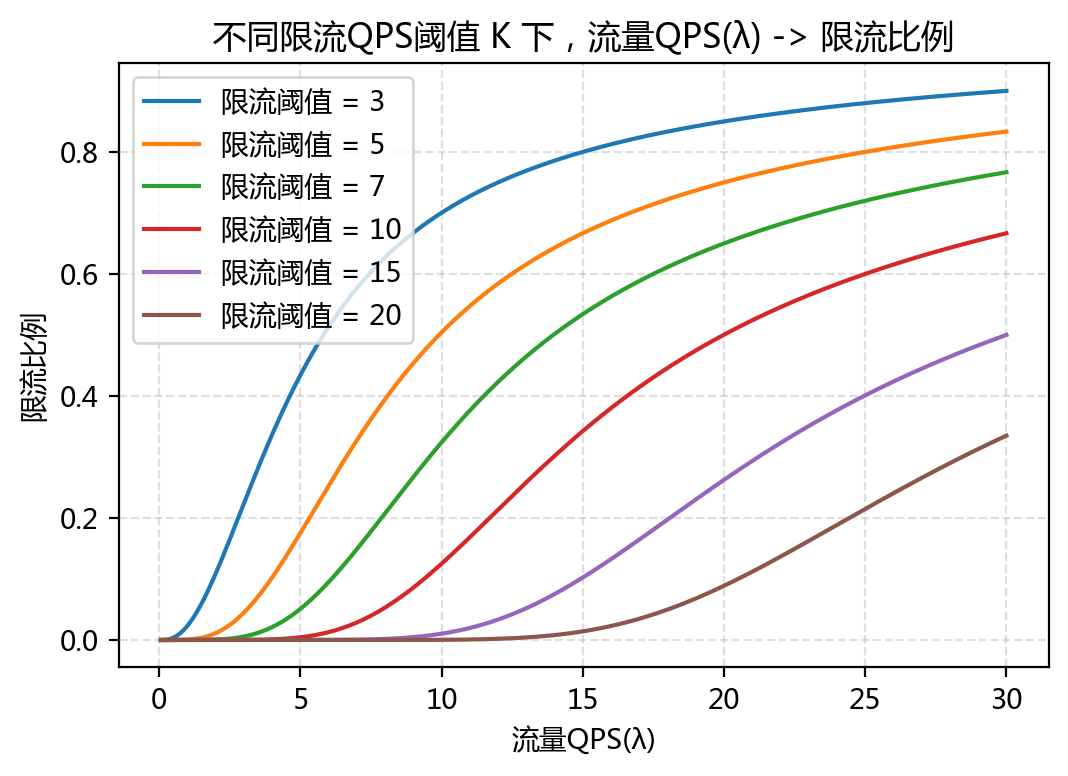

In [3]:
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

def plot_limited_ratio_K(x, K):
    plt.plot(x, limited_ratio_vector(lmd_vec=x, K=K), label=f"限流阈值 = {K}")


def batch_plot_limited_ratio_K(x, Ks):
    for K in Ks:
        plot_limited_ratio_K(x, K)


batch_plot_limited_ratio_K(
    np.linspace(0, 30, 500)[1:], # slice remove first 0
    [3, 5, 7, 10, 15, 20])

plt.xlabel('流量QPS(λ)')
plt.ylabel('限流比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同限流QPS阈值 K 下，流量QPS(λ) -> 限流比例")

plt.legend()

plt.show()

## 6.2 限流`QPS`阈值 $K >= 20$

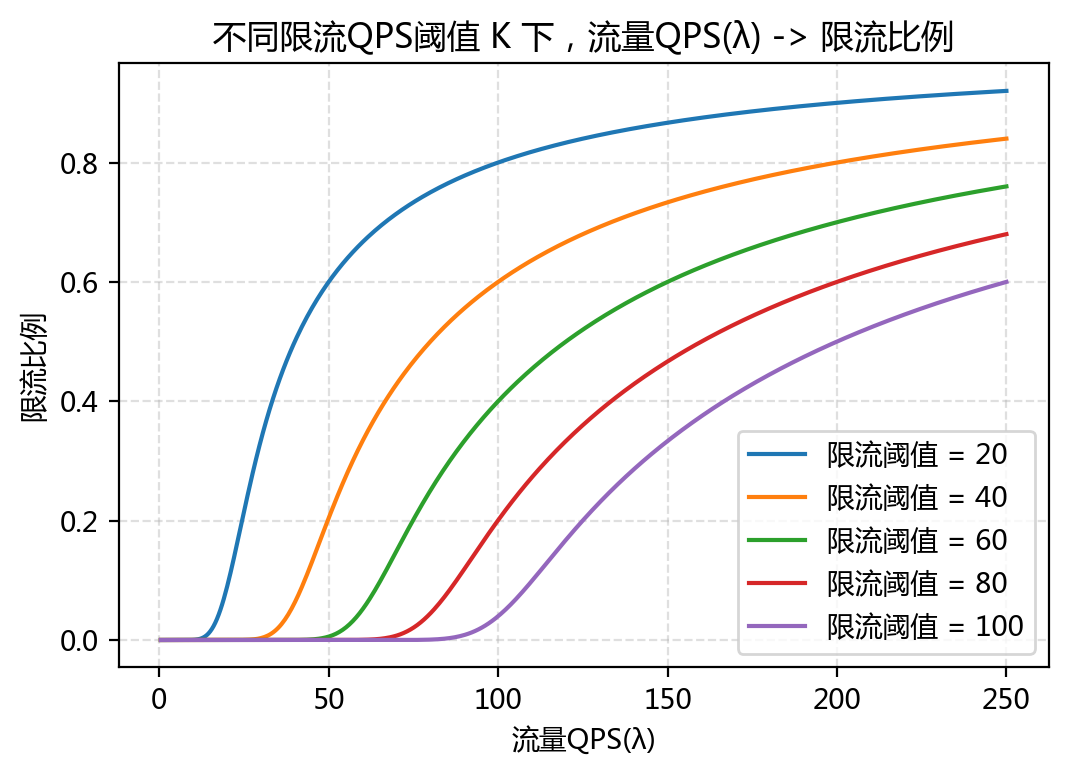

In [4]:
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_limited_ratio_K(
    np.linspace(0, 250, 500)[1:], # slice remove first 0
    [20, 40, 60, 80, 100])

plt.xlabel('流量QPS(λ)')
plt.ylabel('限流比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同限流QPS阈值 K 下，流量QPS(λ) -> 限流比例")

plt.legend()

plt.show()

## 6.3 显然，**限流比例**

- **随 流量`QPS`($\lambda$) ，单调递增。**    
    .    
- ${\lim\limits_{\lambda \to +\infty}} LimitedRatio(\lambda, K) = 1$  
    .
- **随 限流`QPS`阈值 $K$ ，单调递减。**     
    .    
- ${\lim\limits_{K \to +\infty}} LimitedRatio(\lambda, K) = 0$

\# 这个『显然』，看看图、用直觉感受 得出 就好 😂

# 相关资料

## 数值/科学计算

- [Factorial of a matrix elementwise with Numpy](https://stackoverflow.com/questions/30879063)
- [numpy中矩阵乘法，星乘(*)和点乘(.dot)的区别 - CSDN博客](https://blog.csdn.net/like4501/article/details/79753346)